In [1]:
# The intent of the notebook is to begin modelling the baseball data. This will likely not be the final model, 
#     however,z it will act as a building block to more advanced models.
# Version: 1.0

In [2]:
import import_ipynb
from sklearn import svm
from pymysql import connect
from sys import path
from pathlib import Path
path.append('../../../') 
from BaseballAnalytics.bin.app_utils.queries import Queries
from BaseballAnalytics.bin.app_utils.common_help import Log_Helper
from pickle import dump, load

In [3]:
# Connect to the database.
conn = connect(host="localhost", user="root", passwd="praquplDop#odlg73h?c", db="baseball_stats_db")
qu = Queries(conn)

In [4]:
# Get all the game ids. The information is returned as 
#    (Game_ID, year, day, month, Home_Score, Vis_Score, Home_Team, Visitng_Team, Home_Win) where a winning home team is flagged at 0.
game_outcomes = qu.get_game_outcomes()         
game_outcomes[0:5]

(('BOS199004090', 1990, 9, 4, 5, 2, 'BOS', 'DET', 0),
 ('CAL199004090', 1990, 9, 4, 4, 7, 'CAL', 'SEA', 1),
 ('CHA199004090', 1990, 9, 4, 2, 1, 'CHA', 'MIL', 0),
 ('HOU199004090', 1990, 9, 4, 4, 8, 'HOU', 'CIN', 1),
 ('KCA199004090', 1990, 9, 4, 6, 7, 'KCA', 'BAL', 1))

In [5]:
# Filter the games past May 15 (Approximentally one week) to acquire some data.
game_outcomes_cpy = list(game_outcomes)
filter_games = []
for game in game_outcomes_cpy:
    if (game[2] < 15 and game[3] < 5):        # Remove all games prior to April 15.
        pass
    else:
        filter_games.append(game)
game_outcomes_cpy = None                      # Send the data to the ether to reserve space.
filter_games[0:10]

[('ATL199004150', 1990, 15, 4, 6, 13, 'ATL', 'CIN', 1),
 ('CAL199004150', 1990, 15, 4, 4, 1, 'CAL', 'MIN', 0),
 ('CHA199004150', 1990, 15, 4, 4, 1, 'CHA', 'CLE', 0),
 ('DET199004150', 1990, 15, 4, 6, 4, 'DET', 'BAL', 0),
 ('HOU199004150', 1990, 15, 4, 4, 5, 'HOU', 'LAN', 1),
 ('KCA199004150', 1990, 15, 4, 4, 5, 'KCA', 'TOR', 1),
 ('MON199004150', 1990, 15, 4, 3, 1, 'MON', 'NYN', 0),
 ('NYA199004150', 1990, 15, 4, 3, 1, 'NYA', 'TEX', 0),
 ('PHI199004150', 1990, 15, 4, 4, 0, 'PHI', 'SLN', 0),
 ('PIT199004150', 1990, 15, 4, 3, 3, 'PIT', 'CHN', 0)]

In [6]:
# Retrieve only the game ids and their outcomes.
game_ids = [[game_id[0], game_id[8]] for game_id in filter_games]
game_ids = game_ids[200:]                                   # Cut off the first 200 games.
print("The number of game ids: {}".format(len(game_ids)))
game_ids[0:5]

The number of game ids: 65734


[['LAN199005020', 0],
 ['MON199005020', 1],
 ['NYA199005020', 1],
 ['NYN199005020', 0],
 ['PHI199005020', 0]]

In [7]:
# Fetch the players and pitchers from the game.
data_locs = Path(r'C:\Users\micha\Documents\Baseball_Analytics_Source_Data\model_v1')
pitchers_pickle = 'game_pitchers.pickle'
batters_pickle = 'game_players.pickle'
offensive_feat_pickle = 'raw_offensive_features.pickle'
offensive_features = qu.get_all_offensive_features(data_locs / offensive_feat_pickle)
all_pitcher = qu.get_pitchers_in_all_games_vOne(data_locs / pitchers_pickle)
all_batters = qu.get_batters_in_all_games_vOne(data_locs / batters_pickle)

In [8]:
# Gather all the features from every game.
features_pickle = 'game_features.pickle'
#lh = Log_Helper()
#all_features = {}
#num_games = len(game_ids)
#lh.print_progress_bar(0, num_games, prefix = 'Progress:', suffix = 'Complete', length = 50)    # Initial call to print 0% progress
#for num, game_id in enumerate(game_ids):
#    try:
#        all_features[game_id[0]] = qu.get_game_features(all_batters, all_pitcher, offensive_features, game_id[0])
#    except Exception:
#        print("An error as occurred at {}".format(game_id[0]))
#    lh.print_progress_bar(num + 1, num_games, prefix = 'Progress:', suffix = 'Complete', length = 50)
#with open(data_locs / features_pickle, 'wb') as f:
#    dump(all_features, f)
with open(data_locs / features_pickle, 'rb') as f: all_features = load(f)

In [9]:
# Now the modelling can begin. Organise both the Features and Outcomes in the correct order.
y = []
X = []
for game_id in game_ids:
    if game_id[0] in all_features:
        y.append(game_id[1])
        X.append(all_features[game_id[0]])
print(len(all_features))
print(y[0])
print(X[0])

65688
0
[4.25, 1.26328, 2.25, 0.3125, 0.45, 0.3125, 0.21666, 0.29, 0.21666, 0.37333, 0.445, 0.55333, 0.24, 0.29833, 0.39334, 0.15833, 0.18333, 0.18333, 0.31166, 0.36166, 0.37, 0.37501, 0.38334, 0.43334, 0.3, 0.325, 0.38334, 0.125, 0.25, 0.125, 4.5, 1.01, 1.75, 0.24833, 0.28333, 0.34833, 0.18333, 0.28999, 0.35, 0.13333, 0.28333, 0.25, 0.215, 0.24, 0.41, 0.5, 0.51667, 0.75833, 0.12962, 0.25, 0.26851, 0.34333, 0.39667, 0.48833, 0.225, 0.29667, 0.225, 0.0, 0.0, 0.0]


In [13]:
# Split the data for modelling.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

In [28]:
from sklearn import svm
sm = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)
sm.score(X_test, y_test)

0.5337189831024509

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=15, random_state=0).fit(X_train, y_train)
rf.score(X_test, y_test)

0.5440430282118937

In [23]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=5000).fit(X_train, y_train)
print(lr.score(X_test, y_test))
print(lr.coef_, lr.intercept_)

0.5532778567079358
[[-0.07175429  0.10634249  0.05193398  0.2251236  -0.19435592 -0.06473207
   0.00178549 -0.20270362 -0.04754396  0.32745137 -0.37324349 -0.10966464
   0.5516693  -0.67251123 -0.08051948  0.73900439 -0.55608121 -0.20862778
   0.2813729  -0.22839817 -0.08237386  0.11809046 -0.5659829   0.15686493
   0.02217052 -0.10519745  0.02890252 -0.55273979  0.27482107 -0.04339487
   0.0673156  -0.10315434 -0.06439961 -0.39850956  0.47965002  0.11149326
  -0.69929113  0.32173074  0.21772313 -0.4086201   0.32509844  0.13520016
   0.03831717  0.27814908  0.02033522 -0.38349286  0.72720978  0.00545506
   0.16050857  0.23148566 -0.07822415 -0.29018108  0.22959167  0.16326028
  -0.43189139  0.51066856  0.06191339 -0.07348543  0.13814727  0.08151167]] [-0.16401581]


In [32]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=1, max_iter=2000).fit(X_train, y_train)
mlp.score(X_test, y_test)

0.5222256051149338

Confusion matrix, without normalization
[[5122 1828]
 [4012 2176]]
Normalized confusion matrix
[[0.73697842 0.26302158]
 [0.64835165 0.35164835]]


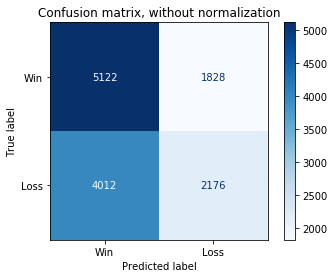

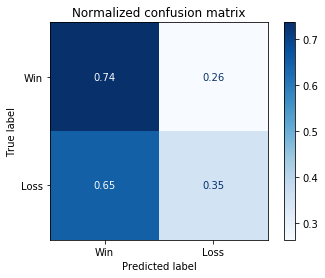

In [30]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, X_test, y_test,
                                 display_labels=['Win', 'Loss'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [21]:
# Use cross validation to get a better idea of the models success.
from sklearn.model_selection import cross_val_score
lr_cv = LogisticRegression(max_iter=2000)
cv_scores = cross_val_score(lr_cv, X, y, cv=5)
print(cv_scores)

TypeError: __init__() got an unexpected keyword argument 'normalize'

In [20]:
rf_cv = RandomForestClassifier(max_depth=15, random_state=0)
cv_scores = cross_val_score(rf_cv, X, y, cv=5)
print(cv_scores)

[0.53607855 0.54970315 0.5449079  0.54198067 0.54631956]


In [24]:
for i in all_pitcher:
    print(all_pitcher[i])
    break

[[0, 'langm001', '0ANA199704020'], [0, 'langm001', '10ANA199704020'], [0, 'langm001', '11ANA199704020'], [0, 'langm001', '12ANA199704020'], [1, 'gordt001', '13ANA199704020'], [1, 'gordt001', '14ANA199704020'], [1, 'gordt001', '15ANA199704020'], [1, 'gordt001', '16ANA199704020'], [1, 'gordt001', '17ANA199704020'], [0, 'langm001', '18ANA199704020'], [0, 'langm001', '19ANA199704020'], [0, 'langm001', '1ANA199704020'], [0, 'langm001', '20ANA199704020'], [0, 'langm001', '21ANA199704020'], [0, 'langm001', '22ANA199704020'], [0, 'langm001', '23ANA199704020'], [1, 'gordt001', '24ANA199704020'], [1, 'gordt001', '25ANA199704020'], [1, 'gordt001', '26ANA199704020'], [1, 'gordt001', '27ANA199704020'], [1, 'gordt001', '28ANA199704020'], [1, 'gordt001', '29ANA199704020'], [0, 'langm001', '2ANA199704020'], [0, 'langm001', '30ANA199704020'], [0, 'langm001', '31ANA199704020'], [0, 'langm001', '32ANA199704020'], [1, 'gordt001', '33ANA199704020'], [1, 'gordt001', '34ANA199704020'], [1, 'gordt001', '35ANA

In [28]:
print(y_train.count(1))
print(y_train.count(0))

26299
29535


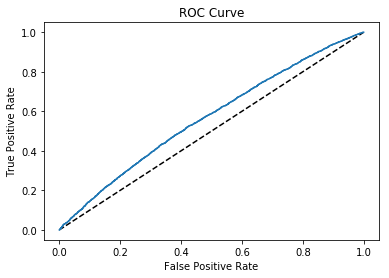

In [31]:
# Build an ROC for the Logistical Regression
# Import necessary modules
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute predicted probabilities: y_pred_prob
y_pred_prob = lr.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()